In [133]:
from __future__ import annotations
import time
import tkinter
import pathlib
import pickle
import tifffile
import os
import numpy as np
from PIL import (Image, ImageTk, ImageDraw)
from tkinter import filedialog, messagebox
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.patches import Rectangle, Circle
from matplotlib.backend_bases import MouseEvent
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from skimage import measure
import fishCore
import threading
import concurrent.futures
import cv2
import imageio.v3 as iio
import napari

In [134]:
def helper__hdr2Rgb(hdr_image: np.ndarray, dynamic_range: int) -> np.ndarray:
        scale_factor = 255 / dynamic_range # 65536
        scaled_image = (hdr_image * scale_factor).astype(np.uint8)
        rgb_image = np.stack((scaled_image,) * 3, axis=-1)
        return rgb_image

def helper__hdr2RgbNorm(hdr_image: np.ndarray, brightness_factor: int) -> np.ndarray:
        img_normalized = cv2.normalize(hdr_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
        return np.clip(img_rgb * brightness_factor, 0, 255).astype(np.uint8)

In [135]:
image_path = pathlib.Path("./multi_channel_tifs/mc1.tif")
img_np = tifffile.imread(image_path)


In [136]:
print(img_np.shape) # (2, H, W)

(2, 2048, 2048)


In [137]:
img_np_1 = img_np[0]
img_np_2 = img_np[1]

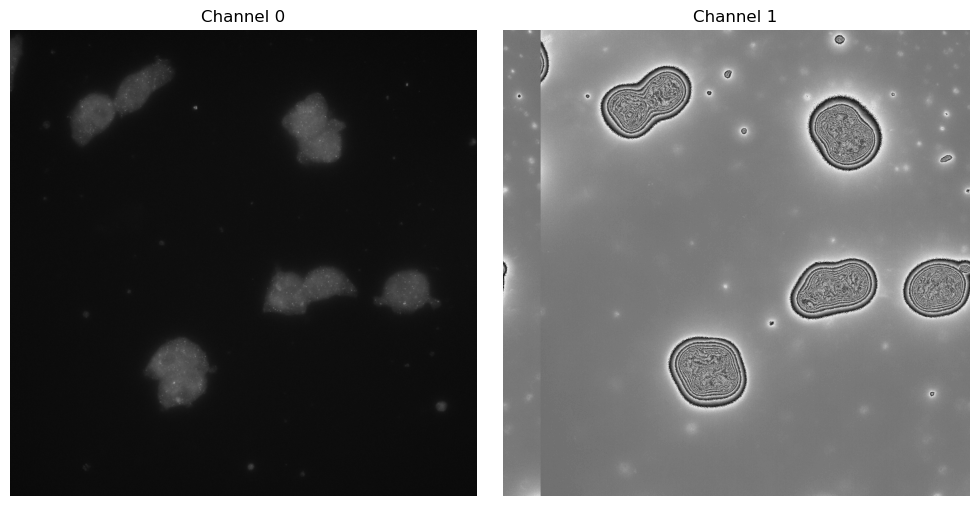

In [138]:
import tifffile
import matplotlib.pyplot as plt

# Load the TIFF
img = tifffile.imread(image_path)  # shape: (2, H, W)
img = img.transpose(1, 2, 0)  # shape: (H, W, 2)

# Plot both channels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img[:, :, 0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(img[:, :, 1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [139]:
from aicsimageio import AICSImage

img = AICSImage(image_path)  # or .czi, .ome.tif, etc.

print(img.dims)   # e.g., 'TCZYX'
img.dtype

<Dimensions [T: 1, C: 2, Z: 1, Y: 2048, X: 2048]>


dtype('uint16')

In [140]:
raw = img.data  # shape: (1, 2, 1, Y, X) — TCZYX
img_data = raw[0, :, 0, :, :]  # -> (C, Y, X)
print(img_data.dtype, img_data.min(), img_data.max())


uint16 0 65294


In [141]:
# Get image data in (C, Y, X) format
data = img.get_image_data("CYX")  # shape: (2, 2048, 2048)

def shift_channel(img, x_shift=0, y_shift=0):
    shifted = np.roll(img, shift=y_shift, axis=0)  # shift Y
    shifted = np.roll(shifted, shift=x_shift, axis=1)  # shift X
    return shifted


data[1] = shift_channel(data[1], x_shift=-165, y_shift=0)

# Launch Napari viewer
viewer = napari.Viewer()

# Add each channel as a separate layer
for i in range(data.shape[0]):
    viewer.add_image(
        data[i],
        name=f"Channel {i}",
        colormap='green' if i == 0 else 'magenta',  # customize per channel
        blending='additive',  # makes overlays look better
        opacity=0.7 if i == 1 else 1.0
    )

napari.run()